# CIS 5450 Final Project: Chess Analysis
## Annabella Tian, Tommy Yu, Rushil Roy

For this data analytics project, we used a dataset comprising 3.5 million chess games. This  dataset encompassed a multitude of attributes, including the ELO levels of each player—a numerical representation of their skill and rank in the realm of chess. Beyond ELO levels, the dataset had information such as the sequence of moves played, the ultimate result of each game, the timestamp indicating when the games transpired, and an insightful indicator of whether the game ended in a checkmate or not.

Our primary objective throughout this project was to gain meaningful insights . We sought to uncover patterns, trends, and relationships within the dataset that could be indicators of the dynamic of the chess gameplay. Our main goal was to develop predictive models on the outcome of chess games based on several of contributing factors.

While we started with our base dataset, we ended up joining it with another dataset on openings in chess, which allowed us to consider more factors in the ultimate predictive models that we created. Throughout the course of the project, we learned to apply the skills we learned in the course to a real-world project that resulted in a model that had applications in the world of chess and beyond.

# Set-Up


In [ ]:
# https://www.kaggle.com/datasets/milesh1/35-million-chess-games/data
# https://chess-research-project.readthedocs.io/en/latest/
# https://github.com/Destaq/chess-graph/tree/master
# https://rpubs.com/dzhen1/chessprediction

'''
data dictionary:
DERIVED COLUMNS
checkmate: 1 if game ended in checkmate (moves string ended with ‘#’) 0 otherwise
first_capture: move number first piece was captured on
first_capture_side: the side that performed the first capture
first_check: move number first check(or possible checkmate) was given
first_check_side: side that performed that first check
white_castle: move number when white first castled, -1 if they never did
black_castle: move number when black first castled, -1 if they never did
first_castle: 1 if white castled first, -1 if black did, 0 if neither castled
white_development_percent_5/10/15/total: 3 columns, each showing the percentage of whites first 5/10/15/total moves were non-pawn moves (these are generally called ‘development moves’ and are associated with better middle/end games)
black_development_percent_5/10/15/total: 3 columns, each showing the percentage of blacks first 5/10/15/total moves were non-pawn moves (these are generally called ‘development moves’ and are associated with better middle/end games)
'''

'\ndata dictionary:\nDERIVED COLUMNS\ncheckmate: 1 if game ended in checkmate (moves string ended with ‘#’) 0 otherwise\nfirst_capture: move number first piece was captured on\nfirst_capture_side: the side that performed the first capture\nfirst_check: move number first check(or possible checkmate) was given\nfirst_check_side: side that performed that first check\nwhite_castle: move number when white first castled, -1 if they never did\nblack_castle: move number when black first castled, -1 if they never did\nfirst_castle: 1 if white castled first, -1 if black did, 0 if neither castled\nwhite_development_percent_5/10/15/total: 3 columns, each showing the percentage of whites first 5/10/15/total moves were non-pawn moves (these are generally called ‘development moves’ and are associated with better middle/end games)\nblack_development_percent_5/10/15/total: 3 columns, each showing the percentage of blacks first 5/10/15/total moves were non-pawn moves (these are generally called ‘develop

In [ ]:
!pip install pyspark
!pip install SQLAlchemy==1.4.46
!pip install pandasql

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandasql as ps
import plotly.express as px
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/chess_dataframe.csv')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.head(5)

,id,date,result,w_elo,b_elo,len,moves,elo_differential,welo_elo_level,belo_elo_level,checkmate,first_capture,first_capture_side,first_check,first_check_side,white_dev_percentage_5,white_dev_percentage_10,white_dev_percentage_15,white_dev_percentage_total,black_dev_percentage_5,black_dev_percentage_10,black_dev_percentage_15,black_dev_percentage_total,elo_band
0,5,2000-02-20,0,2851,2633,97,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bb5 B3.a6 W4.Ba4 ...,218,2800,2600,False,26,-1,88,-1,0.800,0.700,0.667,0.796,0.600,0.500,0.600,0.792,2500+
1,6,2000-05-24,0,2851,2748,52,W1.d4 B1.e6 W2.Nf3 B2.Nf6 W3.c4 B3.d5 W4.Nc3 B...,103,2800,2700,False,8,-1,47,1,0.400,0.700,0.800,0.846,0.400,0.500,0.533,0.654,2500+
2,7,2000-06-19,1,2851,2191,79,W1.e4 B1.c5 W2.Nf3 B2.Nc6 W3.Bb5 B3.g6 W4.Bxc6...,660,2800,2100,False,7,1,73,1,0.600,0.700,0.733,0.750,0.400,0.700,0.733,0.667,2500+
3,9,2000-06-19,0,2851,2175,72,W1.c4 B1.e6 W2.g3 B2.d5 W3.Bg2 B3.Nf6 W4.Nf3 B...,676,2800,2100,False,19,1,40,-1,0.400,0.500,0.533,0.639,0.600,0.600,0.733,0.778,2500+
4,10,2000-01-18,1,2851,2646,49,W1.e4 B1.c5 W2.Nf3 B2.d6 W3.d4 B3.cxd4 W4.Nxd4...,205,2800,2600,False,6,-1,41,1,0.600,0.600,0.667,0.720,0.200,0.300,0.200,0.417,2500+


In [ ]:
#pd.set_option('display.float_format', lambda x: '%.3' % x)
df.describe().loc[['count','mean','std', '25%', '50%', '75%']].T

,count,mean,std,25%,50%,75%
id,1942619.000,1102665.574,669380.512,513479.500,1070709.000,1689886.500
result,1942619.000,0.083,0.804,-1.000,0.000,1.000
w_elo,1942619.000,2241.891,283.305,2132.000,2295.000,2430.000
b_elo,1942619.000,2239.279,284.004,2130.000,2293.000,2430.000
len,1942619.000,76.964,32.569,55.000,75.000,96.000
elo_differential,1942619.000,135.550,118.337,50.000,108.000,186.000
welo_elo_level,1942619.000,2194.600,284.507,2100.000,2200.000,2400.000
belo_elo_level,1942619.000,2191.998,285.212,2100.000,2200.000,2400.000
first_capture,1942619.000,13.252,8.146,6.000,11.000,18.000
first_capture_side,1942619.000,-0.167,0.979,-1.000,-1.000,1.000


# Data Wrangling and Cleaning

To start, we began by turning our data from a txt to a csv file. We read the file and iterated over the lines, stripping white space and separating by spaces. We also made sure to skip corrupted rows. By doing this, we were able to turn the scv file into a Pandas dataframe.

In [ ]:
# # Initialize an empty list to store the data
data = []

# # Open and read the file
with open('/content/drive/My Drive/all_with_filtered_anotations_since1998.txt', 'r') as file:
  for line in file:
      # Skip comment lines
      if line.startswith('#'):
          continue

      # Split the line into parts
      parts = line.strip().split(' ')

      # Check if result, welo, or belo is corrupted
      if parts[7] == 'result_true' or parts[8] == 'welo_true' or parts[9] == 'belo_true':
          continue  # Skip this row as it's corrupted

      # Extract the relevant parts
      game_data = {
          'id': parts[0],
          'date': parts[1],
          'result': parts[2],
          'w_elo': parts[3],
          'b_elo': parts[4],
          'len': parts[5],
          'moves': ' '.join(parts[parts.index('###')+1:])
      }
      data.append(game_data)

"""
        code below is to generate the csv, commented out after generation

        moveCompress = ' '.join(parts[parts.index('###')+1:])
        csvCombo = parts[0]+ "," + parts[1] + "," + parts[2]+ "," + parts[3] + "," + parts[4]+ "," + parts[5] + "," + moveCompress + "\n"
        out.write(csvCombo)
"""
        # Add the parsed data to the list

# Create a DataFrame
# 1953076 rows total
df = pd.DataFrame(data)


In [ ]:
# Convert 'welo' and 'belo' to numeric (float or int)
df['w_elo'] = pd.to_numeric(df['w_elo'], errors='coerce')
df['b_elo'] = pd.to_numeric(df['b_elo'], errors='coerce')

# Compute the elo differential
df['elo_differential'] = df.apply(lambda row: max(row['w_elo'], row['b_elo']) - min(row['w_elo'], row['b_elo']), axis=1)

df['welo_elo_level'] = (df['w_elo'] // 100) * 100
df['belo_elo_level'] = (df['b_elo'] // 100) * 100

In [ ]:
replace_dict = {'1-0': 1, '1/2-1/2': 0, '0-1': -1}
df['result'] = df['result'].replace(replace_dict)

In [ ]:
df['checkmate'] = df['moves'].str[-1]=='#'


def first_capture(moveStr):
  moveSplt = moveStr.split()
  for i, move in enumerate(moveSplt, 1):
    if 'x' in move:
      return i
  return -1


def frst_check(moveStr):
  moveSplt = moveStr.split()
  for i, move in enumerate(moveSplt, 1):
    if '+' in move or '#' in move:
      return i
  return -1

df['first_capture'] = df['moves'].apply(first_capture)
df['first_capture_side'] = df['first_capture'].apply(lambda x: 0 if x == -1 else 1 if x%2==1 else -1)

df['first_check'] = df['moves'].apply(frst_check)
df['first_check_side'] = df['first_check'].apply(lambda x: 0 if x == -1 else 1 if x%2==1 else -1)

In [ ]:
def white_castle_protection(moveStr):
  moveSplt = moveStr.split()
  for i, move in enumerate(moveSplt, 1):
    if 'O-O' in move and move.startswith('W'):
      return i
  return -1

def black_castle_protection(moveStr):
  moveSplt = moveStr.split()
  for i, move in enumerate(moveSplt, 1):
    if 'O-O' in move and move.startswith('B'):
      return i
  return -1

  df['white_castle'] = df['moves'].apply(white_castle_protection)
  df['black_castle'] = df['moves'].apply(black_castle_protection)
  df['first_castle'] = df.apply(lambda game: 0 if game['white_castle'] == game['black_castle'] else (-1 if game['black_castle'] < game['white_castle'] or game['white_castle'] == -1 else 1), axis=1)

In [ ]:
def white_development_percent(moveStr, numDeep):
  white_first_moves = moveStr.split()[::2]
  maxMoves = min(numDeep, len(white_first_moves))
  if (maxMoves < len(white_first_moves)):
    white_first_moves = white_first_moves[:maxMoves]
  if maxMoves < 1:
    return 0
  else:
    devMoves = sum(1 for move in white_first_moves if move[move.find('.') + 1].isupper())
    return devMoves/maxMoves


def black_development_percent(moveStr, numDeep):
  black_first_moves = moveStr.split()[1::2]
  maxMoves = min(numDeep, len(black_first_moves))
  if (maxMoves < len(black_first_moves)):
    black_first_moves = black_first_moves[:maxMoves]
  if maxMoves < 1:
    return 0
  else:
    devMoves = sum(1 for move in black_first_moves if move[move.find('.') + 1].isupper())
    return devMoves/maxMoves

df['white_dev_percentage_5'] = df['moves'].apply(lambda x: white_development_percent(x, 5))
df['white_dev_percentage_10'] = df['moves'].apply(lambda x: white_development_percent(x, 10))
df['white_dev_percentage_15'] = df['moves'].apply(lambda x: white_development_percent(x, 15))
df['white_dev_percentage_total'] = df['moves'].apply(lambda x: white_development_percent(x, 601))
#opening/book moves
df['black_dev_percentage_5'] = df['moves'].apply(lambda x: black_development_percent(x, 5))
df['black_dev_percentage_10'] = df['moves'].apply(lambda x: black_development_percent(x, 10))
df['black_dev_percentage_15'] = df['moves'].apply(lambda x: black_development_percent(x, 15))
df['black_dev_percentage_total'] = df['moves'].apply(lambda x: black_development_percent(x, 601))

In [ ]:
df['len'] = pd.to_numeric(df['len'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
df = df[df['len'] != 0]
df['elo_band'] = pd.cut(df['w_elo'], bins=[0, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, float('inf')], labels=['<1200', '1200-1300', '1300-1400', '1400-1500', '1500-1600', '1600-1700', '1700-1800', '1800-1900', '1900-2000', '2000-2100', '2100-2200', '2200-2300', '2300-2400', '2400-2500', '2500+'])
# df

In [ ]:
def preprocess_and_split_moves(moves):
    if not isinstance(moves, str):
        return ''
    moves = re.sub(r"[WB]\d+\.", "", moves).strip()
    moves_list = moves.split()
    return ' '.join(moves_list)

chunk_size = 5000  # chunk size to reduce space

for start in range(0, len(df), chunk_size):
    end = min(start + chunk_size, len(df))
    df.loc[start:end, 'moves'] = df.loc[start:end, 'moves'].apply(preprocess_and_split_moves)

# Exploratory Data Analysis

In [ ]:
df.columns

Index(['id', 'date', 'result', 'w_elo', 'b_elo', 'len', 'moves',
       'elo_differential', 'welo_elo_level', 'belo_elo_level', 'checkmate',
       'first_capture', 'first_capture_side', 'first_check',
       'first_check_side', 'white_dev_percentage_5', 'white_dev_percentage_10',
       'white_dev_percentage_15', 'white_dev_percentage_total',
       'black_dev_percentage_5', 'black_dev_percentage_10',
       'black_dev_percentage_15', 'black_dev_percentage_total', 'elo_band'],
      dtype='object')

## Outcome Distribution by ELO Level

In [ ]:
# Graph showing the percentage of each possible result for each Elo Band
elo_outcome_counts = df
elo_outcome_counts = elo_outcome_counts.groupby(['elo_band', 'result']).size().unstack()
elo_outcome_percentages = elo_outcome_counts.div(elo_outcome_counts.sum(axis=1), axis=0) * 100
elo_outcome_percentages.reset_index(inplace=True)
elo_outcome_percentages = elo_outcome_percentages.melt(id_vars='elo_band', var_name='Outcome', value_name='Percentage')

fig = px.bar(elo_outcome_percentages, x='elo_band', y='Percentage', color='Outcome', barmode='stack',
             labels={'elo_band': 'Elo Band', 'Percentage': 'Percentage of Games', 'Outcome': 'Outcome'},
             title='Outcome Distribution by Elo Levels',
                 width=800, height=400)

fig.update_layout(legend=dict(title='Outcome', orientation='h', y=1.1, x=0.5, xanchor='center'),
                  xaxis_title='Elo Band', yaxis_title='Percentage of Games')
newnames = {'-1':'black wins', '0': 'draw', '1':'white wins'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig.show()

Takeaways:
*   Based on the bar plot, we can see an obvious correlation between the elo band and the outcome distribution.
*   The higher ELO players have more draws which is oftentimes true in higher level games where neither can force the other into checkmate. Additionally, we can see that higher ELOs have a greater bias against black as it is generally known that white has a slight advantage from the start.
*   This graph is good for considering before we start our modelling as we can see that the ELO band of the player has a pretty obvious correlation to the result of the game.

## First Capture and Check Move Number by White ELO Level

We can use these graphs to evaluate aggressiveness based on how early in the game players at different ELO levels make their first capture and check, indicating varying levels of aggressiveness or defensive strategies.

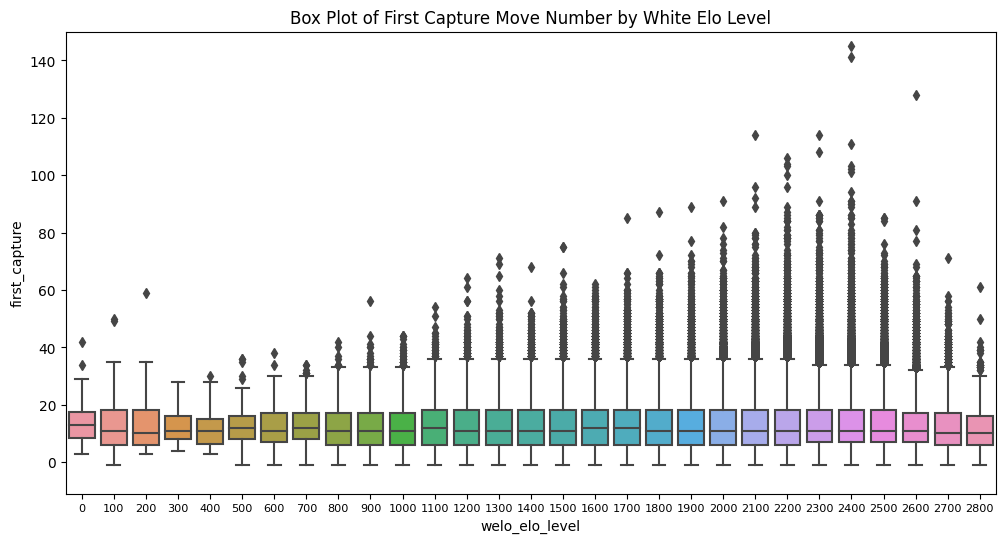

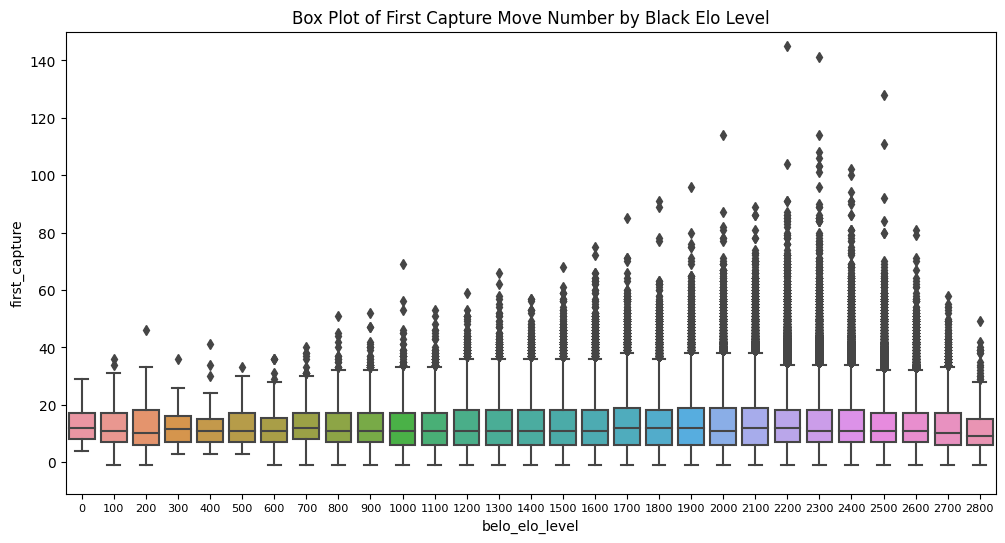

In [ ]:
#Box Plot of First Capture Move Number by Elo Level
plt.figure(figsize=(12, 6))
sns.boxplot(x='welo_elo_level', y='first_capture', data=df, orient='v')
plt.title('Box Plot of First Capture Move Number by White Elo Level')
plt.ylim(top=150)
plt.xticks(fontsize=8.1)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='belo_elo_level', y='first_capture', data=df, orient='v')
plt.title('Box Plot of First Capture Move Number by Black Elo Level')
plt.xticks(fontsize=8.1)
plt.ylim(top=150)
plt.show()

Takeaways:
*   Based on the box plot, the turn at which players make their first capture doesn't vary by much across the ELO levels. However, we can see that there are generally most outliers the higher the ELO.
*   This implies that higher ELO players generally may wait longer until the first capture, which can be indicative of their skill level as they don't take the first/every opportunity to take pieces. Also, it may indicate that as they higher ELO players play against other high ELO players (generally), both sides take longer to capture pieces as defensive playing.
*   We can see that the outliers decrease at the highest ELO levels, perhaps meaning that the skill difference between them and others is more apparent, allowing them to capture earlier.

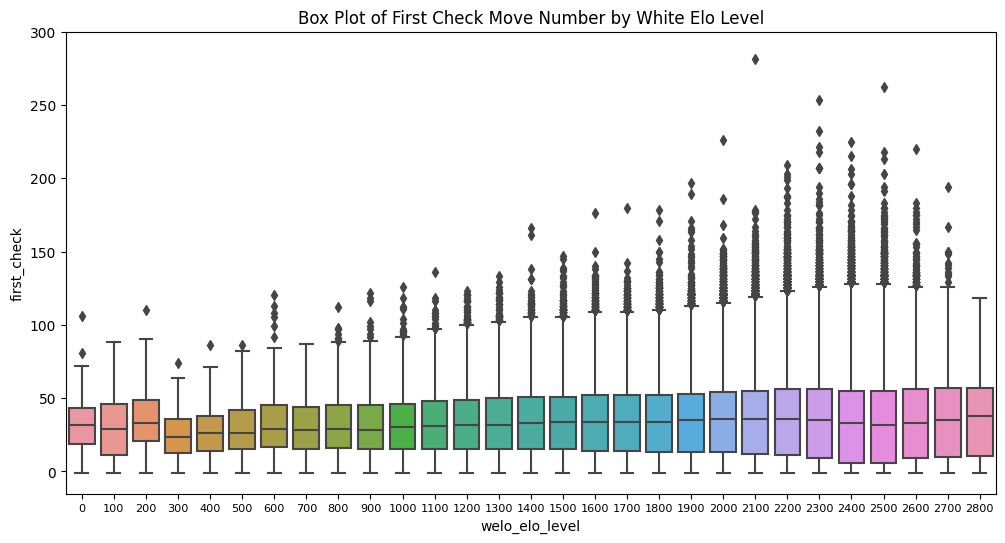

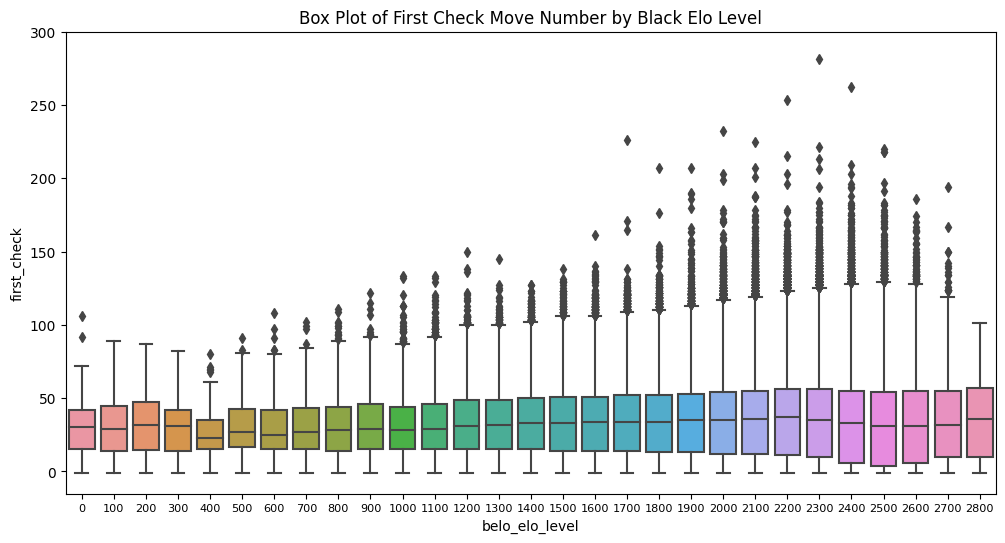

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='welo_elo_level', y='first_check', data=df, orient='v')
plt.title('Box Plot of First Check Move Number by White Elo Level')
plt.ylim(top=300)
plt.xticks(fontsize=8.1)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='belo_elo_level', y='first_check', data=df, orient='v')
plt.title('Box Plot of First Check Move Number by Black Elo Level')
plt.ylim(top=300)
plt.xticks(fontsize=8.1)
plt.show()

Takeaways:
*   Based on the box plot, the turn at which players make their first check doesn't vary by much across the ELO levels. However, we can see that there are generally most outliers the higher the ELO and first check is usually later in the 75% percentile the higher the ELO.
*   This implies that higher ELO players generally may take longer until the first check, which can be indicative of their skill level as they have a more long term or defensive strategy. Also, it may indicate that as they higher ELO players play against other high ELO players (generally), both sides take longer to force each other into check.
*   We can see a decrease at the highest ELO levels, perhaps meaning that the skill difference between them and others is more apparent, allowing them to check earlier.

## ELO Differential vs. Development Percentage Differential

We compared how the difference in ELO (indicative of the difference in skill) is affected by the development percentage difference. Since the ELO differential is likely a factor in who is more likely to win, we can see how this is linked to the difference in the percentage of development.

In [ ]:
# Comparing Elo Differential vs. Development Percentage Differential
query_no_ties = """
    SELECT *,
           CASE WHEN w_elo >= b_elo THEN white_dev_percentage_total - black_dev_percentage_total
                ELSE black_dev_percentage_total - white_dev_percentage_total
           END AS win_dev_diff
    FROM df
    WHERE result != 0
    LIMIT 10000
"""

no_ties_sql = ps.sqldf(query_no_ties, locals())
no_ties = pd.DataFrame(no_ties_sql)
fig = px.scatter(no_ties.head(10000), x='elo_differential', y='win_dev_diff', opacity=0.7, title='Elo Differential vs. Development Percentage Differential',
                 width=800, height=400)
fig.update_layout(
    xaxis_title='Elo Differential',
    yaxis_title='Development Percentage',
    legend=dict(title='Legend', orientation='h', x=1, y=0, xanchor='center', yanchor='bottom'),)
fig.show()

Takeaways:
*   We can see that there is generally less development the greater the ELO difference, which in a real-world sense means that the more dominant a player is, there is less opportunity for development.
*   Since we case on whether the white or black ELO is higher to calculate the development percentage differential, we would expect the development to be more positive, meaning the higher ELO side has more development than the losing side. However, this doesn't seem to be the case.
*   The symmetry of this graph indicates something for our model and analysis. That is, that the development percentage doesn't seem to indicate much about which player has a higher ELO. Therefore, the development percentage may not be a big factor in our modelling.

## ELO vs. Development Percentage

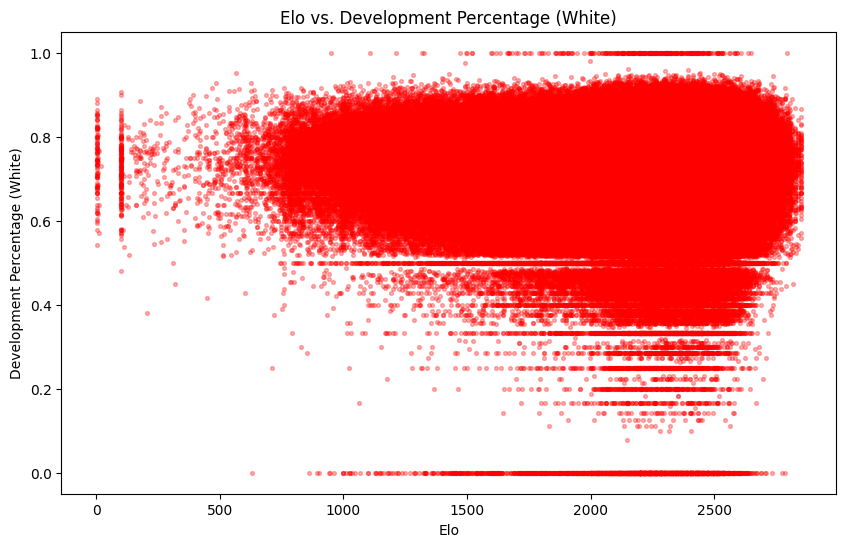

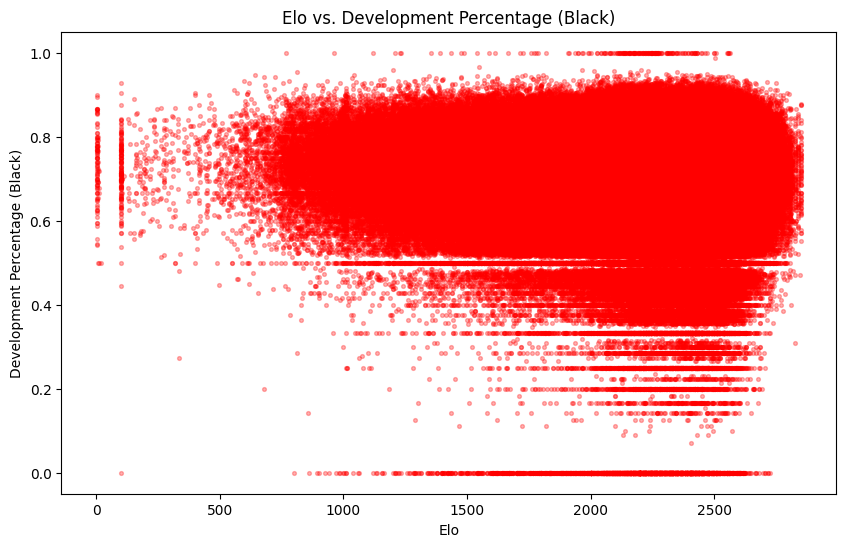

In [ ]:
# Comparing Elo vs. Development Percentage
plt.figure(figsize=(10, 6))
plt.scatter(x='w_elo', y='white_dev_percentage_total', data=df, alpha=0.3, color='red', s=7.5)
plt.title('Elo vs. Development Percentage (White)')
plt.xlabel('Elo')
plt.ylabel('Development Percentage (White)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(x='b_elo', y='black_dev_percentage_total', data=df, alpha=0.3, color='red', s=7.5)
plt.title('Elo vs. Development Percentage (Black)')
plt.xlabel('Elo')
plt.ylabel('Development Percentage (Black)')
plt.show()

Takeaways:
*   These graphs offer some insight on the strategy of players, showing that there is more variance in the development percentage when it comes to higher ELOs.
*   This can show that higher ELO players don't necessarily feel the need to move their non-pawn pieces as much but also they may also be able to win quicker which would mean they would have to move as many of their non-pawn pieces over the course fo the game anyway.
*   Contrary to the last graph, if ELO has a high influence on the result of the game, this graph shower that higher ELOs have more variance in development percentage, which would mean that development percentage may be an important feature in the modelling.

These graphs also re-visualize the prior graph as well, showing the distribution of the development percentage by ELO band, except considering the development percentage for the first 5, 10, and 15 moves.

In [ ]:
# Percentage of Games by white development percentage of first 5 moves and ELO Bands
percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
# We had to switch from pandasql to pandas since the pandasql was forcing our RAM to run out and the session to crash
# query_dfDev5 = f"""
#     SELECT elo_band, white_dev_percentage_5
#     FROM df
#     WHERE white_dev_percentage_5 IN ({', '.join(map(str, percentages))})
# """

# dfDev5 = ps.sqldf(query_dfDev5, locals())
# dfDev5 = pd.DataFrame(dfDev5)
dfDev5 = df[df['white_dev_percentage_5'].isin(percentages)][['elo_band', 'white_dev_percentage_5']]

elo_dev_counts = dfDev5.groupby(['elo_band', 'white_dev_percentage_5']).size().unstack()
elo_dev_percentages = elo_dev_counts.div(elo_dev_counts.sum(axis=1), axis=0) * 100
elo_dev_percentages_long = elo_dev_percentages.reset_index().melt(id_vars='elo_band', var_name='white_dev_percentage_5', value_name='Percentage')

fig = px.bar(
    elo_dev_percentages_long,
    x='elo_band',
    y='Percentage',
    color='white_dev_percentage_5',
    barmode='stack',
    title='Percentage of Games by white development percentage of first 5 moves and ELO Bands',
    labels={'elo_band': 'Elo Band', 'Percentage': 'Percentage of Games', 'white_dev_percentage_5': 'White Dev Percentage 5'},
    width=800, height=400)
fig.update_layout(
    legend=dict(title_text='Legend', orientation='v', x=1.2, y=1),
    yaxis_title='Percentage of Games')
fig.show()

In [ ]:
# Percentage of Games by white development percentage of first 10 moves and ELO Bands
percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# We had to switch from pandasql to pandas since the pandasql was forcing our RAM to run out and the session to crash
# query_dfDev10 = f"""
#     SELECT elo_band, white_dev_percentage_10
#     FROM df
#     WHERE white_dev_percentage_10 IN ({', '.join(map(str, percentages))})
# """

# dfDev10 = ps.sqldf(query_dfDev10, locals())
# dfDev10 = pd.DataFrame(dfDev10)
dfDev10 = df[df['white_dev_percentage_10'].isin(percentages)][['elo_band', 'white_dev_percentage_10']]

percentage_data = dfDev10.groupby(['elo_band', 'white_dev_percentage_10']).size().groupby(level=0).apply(lambda x: x / x.sum() * 100).reset_index(name='percentage')

elo_dev10_counts = dfDev10.groupby(['elo_band', 'white_dev_percentage_10']).size().unstack()
elo_dev10_percentages = elo_dev10_counts.div(elo_dev10_counts.sum(axis=1), axis=0) * 100
elo_dev10_percentages_long = elo_dev10_percentages.reset_index().melt(id_vars='elo_band', var_name='white_dev_percentage_10', value_name='Percentage')

fig = px.bar(
    elo_dev10_percentages_long,
    x='elo_band',
    y='Percentage',
    color='white_dev_percentage_10',
    barmode='stack',
    title='Percentage of Games by white development percentage of first 10 moves and ELO Bands',
    labels={'elo_band': 'Elo Band', 'Percentage': 'Percentage of Games', 'white_dev_percentage_10': 'White Dev Percentage 10'},
    width=800, height=400)
fig.update_layout(
    legend=dict(title_text='Legend', orientation='v', x=1.2, y=1),
    yaxis_title='Percentage of Games')
fig.show()

<ipython-input-21-f01dbada65b3>:13: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



In [ ]:
# Percentage of Games by white development percentage of first 15 moves and ELO Bands
percentages = df.white_dev_percentage_15.value_counts().head(15).index
# We had to switch from pandasql to pandas since the pandasql was forcing our RAM to run out and the session to crash
# query_dfDev15 = f"""
#     SELECT elo_band, white_dev_percentage_15
#     FROM df
#     WHERE white_dev_percentage_15 IN ({', '.join(map(str, percentages))})
# """

# dfDev15 = ps.sqldf(query_dfDev15, locals())
# dfDev15 = pd.DataFrame(dfDev15)
dfDev15 = df[df['white_dev_percentage_15'].isin(percentages)][['elo_band', 'white_dev_percentage_15']]

percentage_data = dfDev15.groupby(['elo_band', 'white_dev_percentage_15'], group_keys=True).size().groupby(level=0).apply(lambda x: x / x.sum() * 100).reset_index(name='percentage')

elo_dev15_counts = percentage_data.groupby(['elo_band', 'white_dev_percentage_15']).size().unstack()
elo_dev15_percentages = elo_dev15_counts.div(elo_dev15_counts.sum(axis=1), axis=0) * 100
elo_dev15_percentages_long = elo_dev15_percentages.reset_index().melt(id_vars='elo_band', var_name='white_dev_percentage_15', value_name='Percentage')

fig = px.bar(
    elo_dev15_percentages_long,
    x='elo_band',
    y='Percentage',
    color='white_dev_percentage_15',
    barmode='stack',
    title='Percentage of Games by white development percentage of first 15 moves and ELO Bands',
    labels={'elo_band': 'Elo Band', 'Percentage': 'Percentage of Games', 'white_dev_percentage_15': 'White Dev Percentage 15'},
    width=800, height=400)
fig.update_layout(
    legend=dict(title_text='Legend', orientation='v', x=1.2, y=1),
    yaxis_title='Percentage of Games')
fig.show()

<ipython-input-22-2a8586acccaf>:13: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



Takeaways:
*   These graphs offer additional insight on the strategy of players. While the distribution for the development percentage in the first 15 moves is evenly distributed, we can see more variance for the first 5 and 10 moves.
*   Lower ELO players have a higher percentage of games with higher development percentage, which indicates that higher ELO players don't necessarily feel the need to move their non-pawn pieces.
*   This may be a stronger indicator for the results of games with lower ELO bands, but after about 1600-1700 ELO, the distribution generally evens out, showing that the development percentage is pretty much indistinguishable after reaching that point.

# Further Feature Engineering and Data Analysis

After our intial exploratory data analysis, we decided that our features were rather simple and uninteresting. Therefore, we chose to add to join our data with another dataset. We looked at openings and used the moves column of our dataset to determine what opening, if any, was used by either the white or black player. We found what the opening was as well as the frequency of that opening in the dataset, then did some further exploratory data analysis.

## Further Feature Engineering

In [ ]:
# loading in openings dataset
openings_df = pd.read_csv('/content/drive/MyDrive/openings_sheet.csv')

In [ ]:
# dropping duplicates and converting to strings
openings_df = openings_df.drop_duplicates(subset='moves', keep='first')
openings_df['ECO'] = openings_df['ECO'].astype(str)
openings_df['name'] = openings_df['name'].astype(str)
openings_df['moves'] = openings_df['moves'].astype(str)

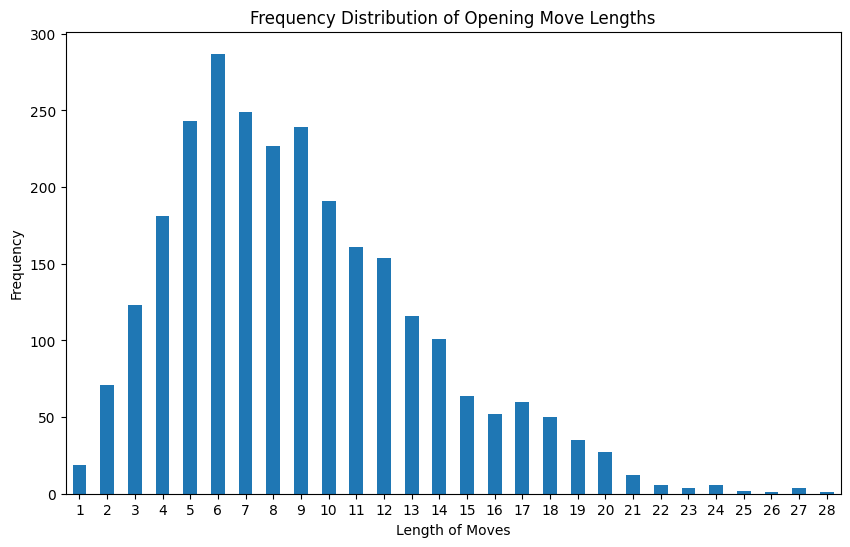

In [ ]:
# plotting the frequency distribution of opening move lengths
openings_df['moves_length'] = openings_df['moves'].str.split().str.len()
plt.figure(figsize=(10, 6))
openings_df['moves_length'].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency Distribution of Opening Move Lengths')
plt.xlabel('Length of Moves')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [ ]:
opening_mapping = {row['moves']: (row['ECO'], row['name']) for _, row in openings_df.iterrows()}

In [ ]:
# mapping openings according to hashmap
def add_opening_features(df, opening_mapping):
    def get_opening_info(moves, opening_mapping):

        moves_list = moves.split()
        for i in range(29, 0, -1):
            opening_moves = ' '.join(moves_list[:i])
            if opening_moves in opening_mapping:
                eco_code, opening_name = opening_mapping[opening_moves]
                return eco_code, opening_name, i
        return 'Unknown', 'Unknown Opening', 0

    # Apply the function to both white and black moves
    df['opening_eco'], df['opening_name'], df['opening_length'] = zip(
        *df['moves'].apply(lambda x: get_opening_info(x, opening_mapping))
    )

    return df

df = add_opening_features(df, opening_mapping)

In [ ]:
opening_freq = df['opening_name'].value_counts()

print("Frequency of Openings:")
print(opening_freq.head(20))

Frequency of Openings:
King's Indian Attack; Reti; Zukertort; A05           80988
Reti; Zukertort; A04                                 42867
Knights Variation, Indian Game; A46                  31570
Horwitz Defense                                      26557
Pirc; Robatsch; Modern; King Pawn Fianchetto; B06    24728
Pseudo-King's Indian Variation; A48                  23078
Alapin; Sveshnikov Var, Sicilian; B22                22663
Four Knights Variation, Sicilian                     20756
French Variation, Sicilian; B40                      20472
A16                                                  18383
Benko; Barczay; Bilek; Hungarian                     16097
Trompowsky; Opocensky; Ruth Opening                  15181
A06                                                  15029
Slav Defense; Czech Defense, QGD; D10                14458
Agincourt; Kurajica Defense, English; A13            14111
Old Sicilian                                         14093
Barcza Opening, Reti; A07        

In [ ]:
df.describe().loc[['count','mean','std', '25%', '50%', '75%']].T

In [ ]:
# frequency encoding for openings
opening_freq = df['opening_name'].value_counts()
df['opening_name_freq'] = df['opening_name'].map(opening_freq)

## Time Series Analysis of Frequency of Most Popular Opening by Year

After adding in the chess opening data, we can look at what the most popular openings are by year, perhaps showing a difference in strategy over time.


In [ ]:
# Time series analysis of frequency of most popular opening by year
time_df = df
time_df['date'] = pd.to_datetime(time_df['date'])
time_df['year'] = time_df['date'].dt.year
time_df = df.dropna(subset=['year'])
time_df['year'] = time_df['year'].astype(int)
time_df = time_df.dropna(subset=['year'])
time_df['year'] = time_df['year'].astype(int)

most_common_opening = time_df.groupby('year')['opening_name'].agg(lambda x: x.value_counts().idxmax()).reset_index()
opening_counts = df.groupby(['year', 'opening_name']).size().reset_index(name='frequency')
opening_counts = pd.merge(most_common_opening, opening_counts, how='left', on=['year', 'opening_name'])

fig = px.scatter(opening_counts, x='year', y='frequency', color='opening_name',
              labels={'frequency': 'Frequency', 'year': 'Year'},
              title='Most Common Chess Opening Frequency Over the Years',
              hover_data=['opening_name'])
fig.show()

<ipython-input-30-92a0d8a445e1>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Takeaways:
*   Firstly, looking at the frequency of the most popular opening, we can tsee that in years before about 1996, there is either a much more spread out distribution of the openings or not as much data. It is likely the latter as out dataset comes from recorded games that were mostly played online.
*   Seeing that the King's Indian Attack is the most common chess opening by far, it is likely difficult to determine who will win based on the opening since there is a very popular opening that likely lots of players no matter their actual likelihood of winning play.

## Pie Chart of Types of Openings

Chess opening use an ECO code to be classified and the first letter of the ECO tells us something about the type of strategy.
* A00-A99: Flank openings.
* B00-B99 Semi-open games (not including the French defence)
* C00-C99 Open games (including the French defence)
* D00-D99 Closed and semi-closed games.
* E00-E99: Indian defences.

Source (https://www.hiarcs.com/hce-manual/pc/ECOopeningnaming.html)

In [ ]:
# Pie graph of the types of openings by opening_eco
pie_df = df.dropna(subset=['opening_eco'])
pie_df['opening_eco_first_char'] = pie_df['opening_eco'].str[0]
pie_df = pie_df[pie_df['opening_eco_first_char'] != 'U']

eco_char_counts = pie_df['opening_eco_first_char'].value_counts().reset_index()
eco_char_counts.columns = ['Character', 'Frequency']

fig = px.pie(eco_char_counts, names='Character', values='Frequency',
             title='Frequency of First Character in Opening ECO Codes')
fig.show()

Takeaways:
*   Looking at the pie chart, we can see a distribution of what types of openings are played. Since the distribution isn't even, it may be possible to look at the lesser played openings and see what percentage of players that play C, D, or E type openings win.
*   The model may be able to use the opening type to predict who is more likely to win. Thus, out opening data can be relatively effective for our models to predict the result.

# Correlation Matrix

## Correlation Matrix of Features

We made a correlation matrix of the columns of our dataframe, allowing us to see which features would be redundant in our modelling.

<ipython-input-32-0384ed3008c4>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



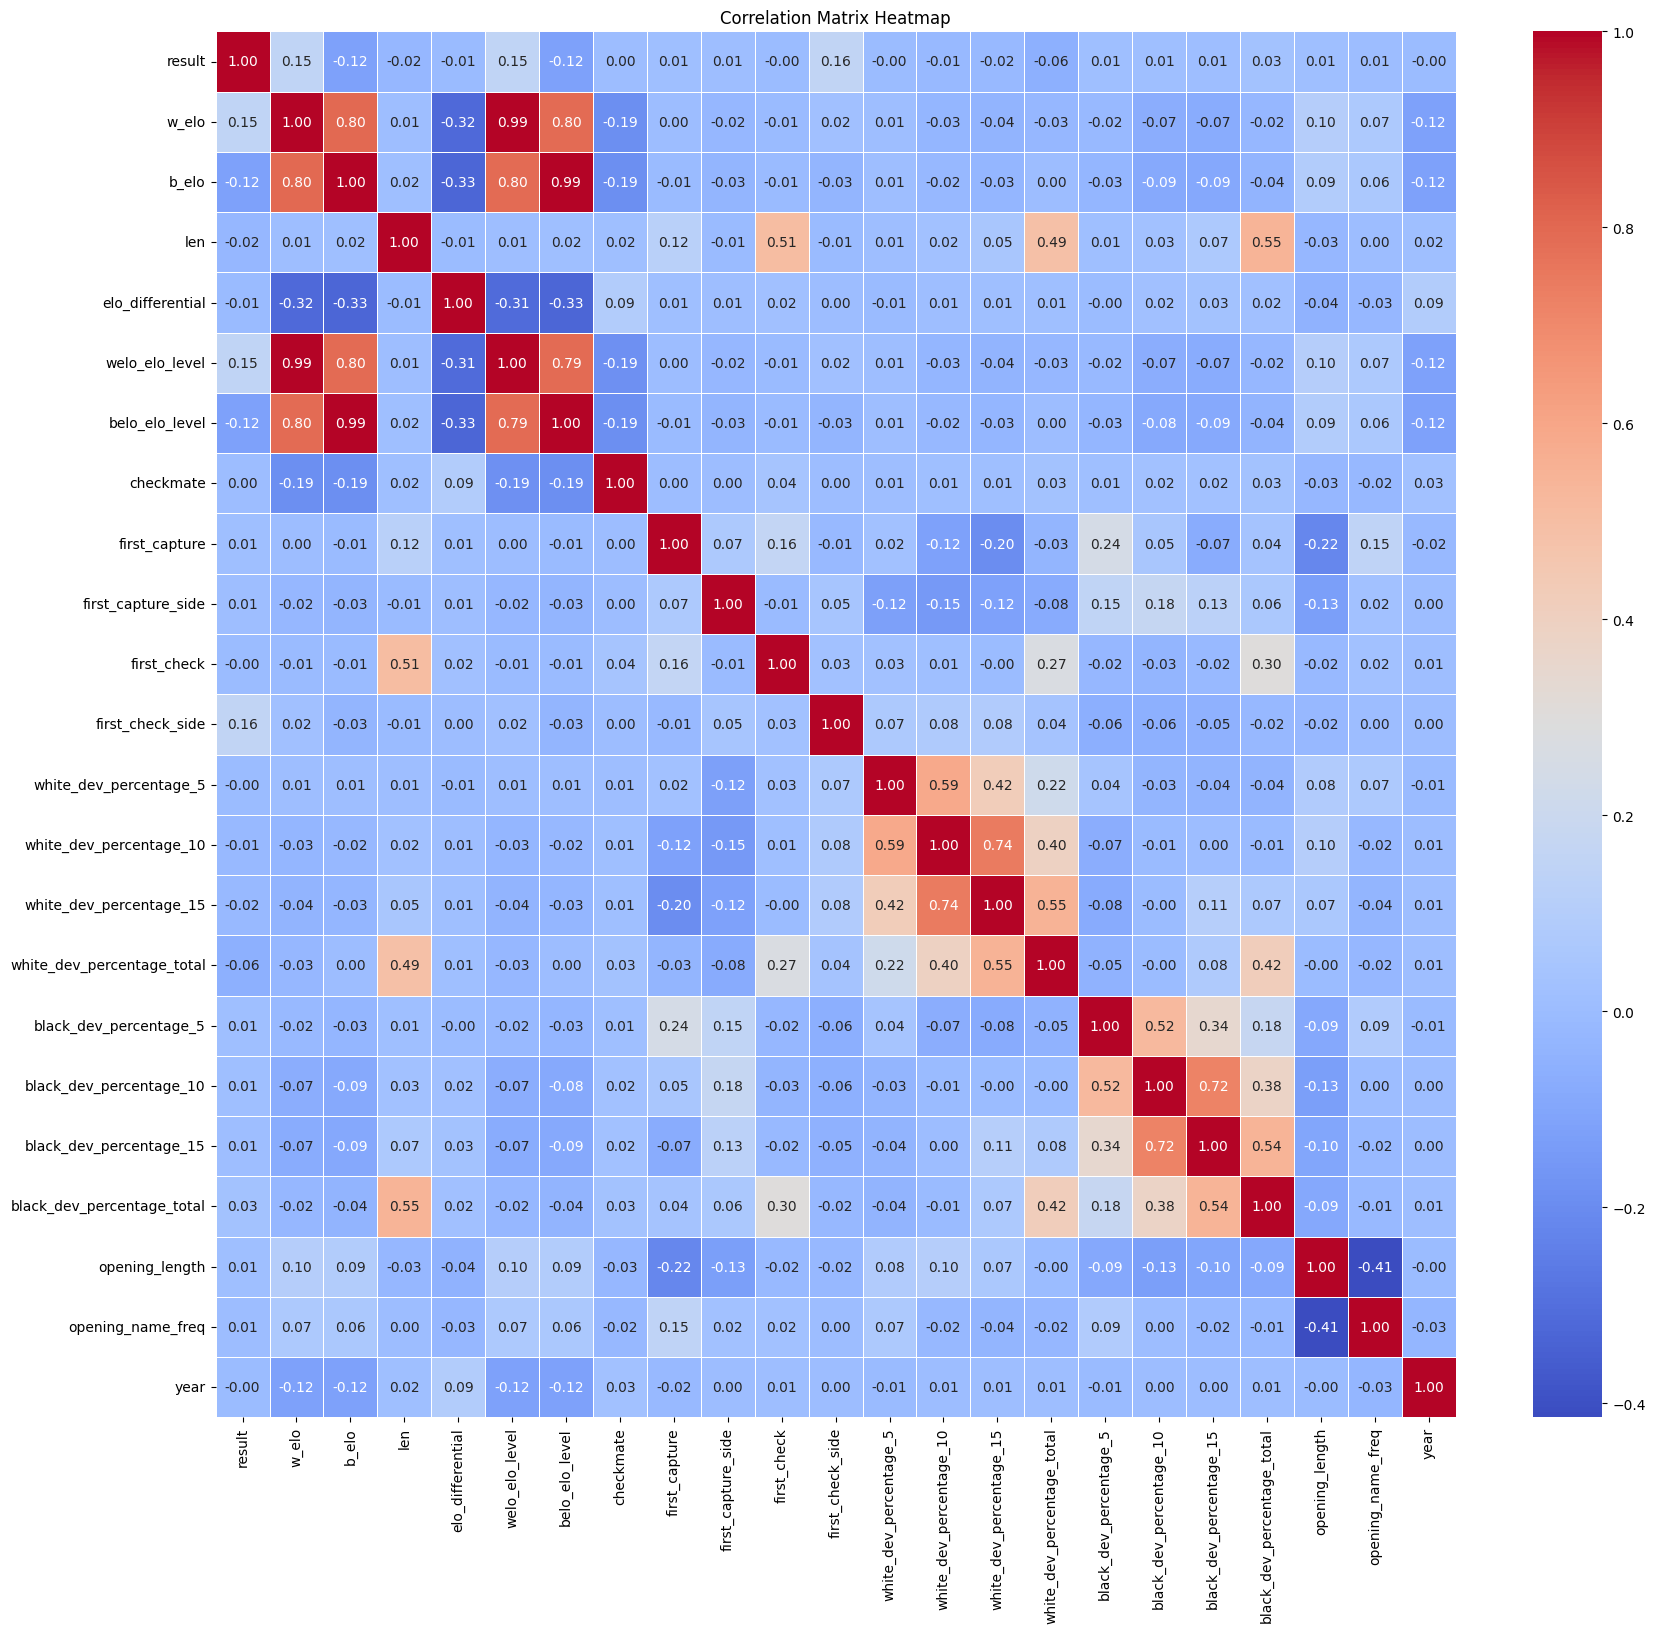

In [ ]:
# Correlation matrix for columns
correlation_matrix = df.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 10}, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix Heatmap')

plt.show()

Takeaways:
*   Most features were uncorrelated, which is good since that indicates each brings a different aspect to the way that a certain chess game is played out.
*   Some features were expectedly correlated such as the development percentages nd the black/white elo and elo level. Other than that, some other correlations included total development percentage with the length of the game which makes sense as the longer the game is, the more pieces will be developed. It makes sense as well that black and white elo would be correlated as players would probably play other people around their same level. Lastly, there is a 0.16 correlation between result and the first side to check which makes it a feature that is much more indicative of result than any other column.

# Modeling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1942619 entries, 0 to 1953074
Data columns (total 29 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   id                          object        
 1   date                        datetime64[ns]
 2   result                      int64         
 3   w_elo                       int64         
 4   b_elo                       int64         
 5   len                         int64         
 6   moves                       object        
 7   elo_differential            int64         
 8   welo_elo_level              int64         
 9   belo_elo_level              int64         
 10  checkmate                   bool          
 11  first_capture               int64         
 12  first_capture_side          int64         
 13  first_check                 int64         
 14  first_check_side            int64         
 15  white_dev_percentage_5      float64       
 16  white_dev_percenta

In [ ]:
temp = df
temp = temp.dropna()
X = temp.drop(['result','id','date','moves','checkmate','elo_band', 'opening_name', 'opening_eco'], axis=1)
y = temp['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Decision Tree Classifier

We first looked at a decision tree to look at what features were impacting our model the most. This was a good starting model as it showed how it was making decisions. This allows us to look at the next modelling with a more informed understnading and determine what features were the most influential in our final analysis.

In [ ]:
# Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

class_names = ['black wins', 'draw', 'white wins']
plt.figure(figsize=(30, 15))
plot_tree(model, filled=True, feature_names=X.columns, class_names=class_names, fontsize=12)
plt.show()

KeyboardInterrupt: ignored

Takeaways from Decision Tree Classifier:

The Decision Tree Classifier was configured with a max_depth of 3 to prevent overfitting and ensure the tree remains interpretable.
The model was trained using the X_train dataset and the predictions were made on the X_test dataset.
The accuracy of the model on the test data was evaluated to be approximately 71.19% (assuming the accuracy matches that from the hyperparameter tuning example).
The decision tree graphic indicates the model's decision process, starting with the root node using the elo_differential feature to split the data.
The Gini impurity suggests that the model's splits were somewhat effective in organizing the classes, with the lowest impurity seen in the left-most branch which is more homogenous.
The class distribution within leaves shows the number of samples that fall into each category of 'black wins', 'draw', and 'white wins'.
The tree structure reveals that elo_differential, first_check, len, b_elo, and w_elo are important features for making predictions.
The plot_tree visualization helps in understanding how the model makes decisions, which is crucial for transparency and interpretability.
This Decision Tree Classifier serves as a baseline model and can be a starting point for more complex models or further analysis.

Feature Importance:

The root node (elo_differential <= 186.5) suggests that the difference in player ratings (ELO) is the most significant feature for predicting the outcome of a chess game. This aligns with domain knowledge, as higher-rated players are generally expected to win more often.
The feature first_check (appearing in a subsequent split) may indicate a strategic advantage, as an early check can pressure an opponent and lead to mistakes.
The features len, b_elo, and w_elo likely represent the length of the game and the individual ELO ratings of black and white players, respectively. The length of the game (len) can be associated with the complexity or phase of the game, with longer games possibly indicating more drawn outcomes or victories by more skilled players who can leverage endgame strategies.

Class Distribution:

The leaf nodes show the distribution of game outcomes ('black wins', 'draw', 'white wins') based on the splits. For example, a lower elo_differential seems to increase the chances of a draw, which makes sense if the players are closely matched in skill.
On the other hand, a high elo_differential leads to a higher proportion of 'white wins', which may reflect a bias in the dataset or an actual advantage for white due to the first-move benefit in chess.

## Logistic Regression

In [ ]:
# Logistic Regression
model = LogisticRegression(penalty = None, multi_class = 'multinomial').fit(X_train, y_train)
y_pred = model.predict(X_test)
log_acc = model.score(X_test, y_test)
targetnames = ['black wins', 'draw', 'white wins']
print(classification_report(y_test, y_pred, target_names=targetnames))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

  black wins       0.58      0.53      0.55     62886
        draw       0.52      0.51      0.51     70097
  white wins       0.60      0.65      0.62     79979

    accuracy                           0.57    212962
   macro avg       0.57      0.56      0.56    212962
weighted avg       0.57      0.57      0.57    212962



Takeaways:
*   The logistic regression had an overall accuracy of about 57% and performed the best in predicting white wins (although this may be generally because white wins are more likely in general).
*   Precision is highest for "white wins" (60%), followed by "black wins" (58%), and lowest for "draw" (51%).
*   The model's performance is slightly weaker for "draw," as shown by the lower precision, recall, and F1-score for this class. Enhancements may be needed to improve predictions for "draw."
*   The weighted average metrics (precision, recall, and F1-score) are around 56%, indicating a moderate overall performance. The balance between precision and recall contributes to a relatively consistent performance across the classes.
*   The macro average of precision, recall, and F1-score is around 56%, suggesting a reasonable consistency in model performance across the classes.

## XGBoost Model

In [ ]:
# XGBoost model
y = y.astype(np.int32)
y_multi = y + 1
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

targetnames = ['black wins', 'draw', 'white wins']
print(classification_report(y_test, y_pred, target_names=targetnames))

              precision    recall  f1-score   support

  black wins       0.70      0.79      0.74     62942
        draw       0.67      0.48      0.56     69913
  white wins       0.73      0.84      0.78     80107

    accuracy                           0.71    212962
   macro avg       0.70      0.70      0.70    212962
weighted avg       0.70      0.71      0.70    212962



Takeaways:
*   The XGBoost model had an overall accuracy of about 71% and performed the best in predicting white wins (although this may be generally because white wins are more likely in general).
*   It still performed the worst in black wins like in the logistic regression, which is only to be expected as there are less black winning samples. However, it drastically improves with a precision rate of 70% compared to 58%.
*   Looking at the f1-score, draws had the lowest, but white wins and and black wins have a generally acceptable f1-score.
*   Overally, the XGBoost improved from the logistic regression and now we can use hyperparameter tuning to improve it further
*   The macro average of precision, recall, and F1-score is around 70%, suggesting that there is variability in performance across the classes.
*  In summary, while the model performs reasonably well, there is potential for improvement, especially in enhancing predictions for "draws." We made potential adjustments that could further enhance its performance.

In [ ]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'learning_rate': [0.2, 0.3],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(best_params)
print(accuracy)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
{'learning_rate': 0.3, 'n_estimators': 200}
0.7104792401271462


The hyperparameter tuning involved fitting 2 folds for each of the 4 candidate parameter sets, totaling 8 fits.
The optimal hyperparameters identified through GridSearchCV were: learning_rate of 0.3 and n_estimators of 200.
With these optimized parameters, the accuracy of the XGBoost model reached approximately 71.05%, showing a minor improvement in performance.
This result confirms that tuning the learning rate and the number of estimators can minorly impact the model's accuracy.
The use of GridSearchCV allowed for a systematic exploration of parameter combinations, ensuring that the best possible model configuration was identified for this specific dataset.
The increased accuracy post-hyperparameter tuning indicates potential for even further enhancements with more extensive tuning or additional parameters.


## Fully Connected Neural Network


We chose to employ a Fully-Connected Neural Network (FCNN) as one of our models to predict chess outcomes, stepping beyond the baseline of logistic regression. This decision was primarily influenced by our dataset's nature. While neural networks are often associated with handling spatially structured data, particularly in the case of Convolutional Neural Networks we explored in class, our chess data lacked this spatial structure. As we saw, CNNs excel in areas where data points have a clear, grid-like arrangement, such as in image processing, by capturing the spatial hierarchies between pixels.

Our chess data, on the other hand, is more abstract and unstructured, lacking these spatial relationships -- in essence, we opted for a model which tends to have a lesser tendency to assume spatial relationships between elements, on the assumption that trying to parse a series of text on the basis of pattern-recognition alone wouldn't truly be conducive to any meaningfully interpretible patterns regarding game end-state. We decided this primarily due to what we predicted may be a high 'false positive' potential of assumign such spatial relationships. Many chess games which play out dramatically differently have contextually unrelated -- yet still notationally identical -- move sequences of arbitrary length in the middle which match up. Given the potential for many 'chess metas' (e.g. advancing the B or G pawn 1 space and moving a Bishop to the space the pawn previously occupied; Castling and then advancing the A or H pawn; etc.) we believed this spatial assumption had a greater potential for harm than good in our model's output.


In [ ]:
#FCNN

class chsFCNN(nn.Module):
  def __init__(self, features):
    super(chsFCNN, self).__init__()
    self.fcLyr1 = nn.Linear(features, 128)
    self.fcLyr2 = nn.Linear(128, 256)
    self.fcLyr3 = nn.Linear(256, 3)

  def forward(self, x):
    reluLayer1 = nn.functional.relu(self.fcLyr1(x))
    reluLayer2 = nn.functional.relu(self.fcLyr2(reluLayer1))
    forX = self.fcLyr3(reluLayer2)
    return nn.functional.log_softmax(forX, dim=1)


dfPRE = df.head(500000)
dfPRE = dfPRE.dropna()


xFCNN = dfPRE.drop('result', axis = 1)
xFCNN = xFCNN.drop('elo_band', axis = 1)
xFCNN = xFCNN.drop('date', axis = 1)
xFCNN = xFCNN.drop('moves', axis = 1)
xFCNN = xFCNN.drop('opening_name', axis = 1)

def ecoFloatMap(eco):
    letter_mapping = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8}
    letter = eco[-3]
    if letter not in letter_mapping.keys():
      return 0.999
    digits = float(eco[-2:]) / 100
    return letter_mapping[letter] + digits

xFCNN['opening_eco'] = xFCNN['opening_eco'].apply(ecoFloatMap)

yFCNN = dfPRE['result']
label_mapping = {-1: 0, 0: 1, 1: 2}
yFCNN = yFCNN.map(label_mapping)


stdSclr = StandardScaler()
xFCNN = stdSclr.fit_transform(xFCNN)

xTrch = torch.tensor(xFCNN, dtype=torch.float32)
yTrch = torch.tensor(yFCNN.values, dtype=torch.long)

#init FCNN
xTrn, xTst, yTrn, yTst = train_test_split(xTrch, yTrch, test_size=0.2, random_state=42)
featCount = xTrn.shape[1]
print(featCount)
model = chsFCNN(featCount)
print(model)

#loss and optimizing
lossCriterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



#DataLoad
PREtrn = TensorDataset(xTrn, yTrn)
PREtrnLoad = DataLoader(dataset=PREtrn, batch_size=64, shuffle=True)
PREtst = TensorDataset(xTst, yTst)
PREtstLoad = DataLoader(dataset=PREtst, batch_size=64, shuffle=False)

#training Loop
epochCount = 10
for epoch in range(epochCount):
    for feat, out in PREtrnLoad:
        optimizer.zero_grad()
        modelRes = model(feat)
        loss = lossCriterion(modelRes, out)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')



#testing Loop
yPredict = []
model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for feat, out in PREtstLoad:
        modelRes = model(feat)
        preA, predict = torch.max(modelRes, 1)
        yPredict.extend(predict.tolist())
        total += out.size(0)
        accurate += (predict == out).sum().item()

print(f'Accuracy: {100 * accurate / total}%')
yPredict = torch.tensor(yPredict, dtype=torch.long)
targetnames = ['black wins', 'draw', 'white wins']
print(classification_report(yTst, yPredict, target_names=targetnames))


23
chsFCNN(
  (fcLyr1): Linear(in_features=23, out_features=128, bias=True)
  (fcLyr2): Linear(in_features=128, out_features=256, bias=True)
  (fcLyr3): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0, Loss: 0.7395675778388977
Epoch 1, Loss: 0.5600584745407104
Epoch 2, Loss: 0.7555367350578308
Epoch 3, Loss: 0.8856004476547241
Epoch 4, Loss: 0.8346189260482788
Epoch 5, Loss: 0.9252413511276245
Epoch 6, Loss: 0.9979026913642883
Epoch 7, Loss: 1.135895013809204
Epoch 8, Loss: 0.8364572525024414
Epoch 9, Loss: 0.6190934777259827
Accuracy: 63.8162360739528%
              precision    recall  f1-score   support

  black wins       0.45      0.28      0.34      7362
        draw       0.67      0.60      0.63     20520
  white wins       0.65      0.79      0.71     22204

    accuracy                           0.64     50086
   macro avg       0.59      0.56      0.56     50086
weighted avg       0.63      0.64      0.63     50086



# Conclusion

Our program started with one of the classic machine learning problems -- given metadata about millions of instances of a game that’s been studied for centuries, reduce all of those variables to a ternary result: win, lose, or draw.

We had 3 key takeaways

*	Even (relatively) underperformant models can yield unique and informative insights. The decision tree model we originally intended to have serve as our ‘baseline’ model to compare all other results with; effectively as a benchmark for other more advance models to beat. However, the more tangible visualization and lack of ‘black-box’ properties in the algorithm made it easier to unmderstand  and visualize more complex relationships between our attributes early on. It demonstrated that some off our derived attributes like first_checkmate were well-engineered predictors for game outcome
*	The Fully-Connected Neural Network (FCNN), despite the non-spatial nature of our data, performed relatively well compared to baseline ne but definitely had room for improvement. Our decision not to fine-tune the model in the interest of experimenting with gradient boosting was ultimately a good one, but reflecting on the increase in success our XGBoost model had, the FCNN definitely had potential for hyper-parameter tuning to bolster its prediction rate
*	XGBoost was by far the most performant model at 71% accuracy post-hyper-tuning. The precision rate particularly also showed dramatic performance increases, particularly after hyper tuning the learning rate and estimator parameters. Despite this, there were still some irregularities in the model’s output which we hope to account for in the future. The XGBoost model, despite its overall effectiveness, mirrored the ‘white wins’ bias of ours other models, indicating a potential need for more effective sampling methods of our database
